In [1]:

import pandas as pd
import numpy as np
import soundfile as sf
import tensorflow as tf
from scipy.io import wavfile
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 
from keras import regularizers
from tensorflow.keras.layers import Conv1D, Flatten
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio
import seaborn as sns
import os
import random
import csv
import re
import tempfile
import zipfile
from pydub import AudioSegment 


C:\Users\H P\anaconda3\envs\ALX_Creating_environment\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:

def data_augmentation_merged(path):
        # Define augmentation functions
    def add_white_noise(signal, noise_percentage_factor):
        noise = np.random.normal(0, signal.std(), signal.size)
        augmented_signal = signal + noise * noise_percentage_factor
        return augmented_signal

    def time_stretch(signal, time_stretch_rate):
        return librosa.effects.time_stretch(signal, rate = time_stretch_rate)

    def pitch_scale(signal, sr, num_semitones):
        return librosa.effects.pitch_shift(signal, sr = sr,_steps=num_semitones)

    def random_gain(signal, min_factor=0.1, max_factor=0.12):
        gain_rate = random.uniform(min_factor, max_factor)
        augmented_signal = signal * gain_rate
        return augmented_signal

    def invert_polarity(signal):
        return signal * -1

    # Directory containing subdirectories with WAV files
    base_dir = path

    # Output directory for augmented files
    output_dir = 'E:/uni/4th year/grad project/final_output_augmented_EYASE_EAED'


    for file_name in os.listdir(base_dir):
        if file_name.endswith('.wav'):
            file_path = os.path.join(base_dir, file_name)

            # Load audio file
            audio, sr = librosa.load(file_path, sr=None)

            # Apply augmentations
            augmented_audios = [
                add_white_noise(audio, noise_percentage_factor=0.1),
                time_stretch(audio, time_stretch_rate=1.2),
                pitch_scale(audio, sr, num_semitones=2),
                random_gain(audio),
                invert_polarity(audio),
                audio
            ]

            # Define abbreviated tags for each augmentation
            augmentation_tags = ['wn', 'ts', 'ps', 'shift', 'sc' , 'normal']

            # Iterate over the augmentations and save augmented files
            for i, augmented_audio in enumerate(augmented_audios):
                # Generate the augmented file name with abbreviated tag
                augmented_file_name = f'{file_name[:-4]}_{augmentation_tags[i]}.wav'
                augmented_file_path = os.path.join(output_dir, augmented_file_name)
                os.makedirs(os.path.dirname(augmented_file_path), exist_ok=True)
                sf.write(augmented_file_path, augmented_audio, sr)


In [3]:
def feature_extraction_merged(directory_path, save_path):
    # Initialize lists to store features and emotion labels
    zcr_list = []
    c_stft_list = []
    mfcc_list = []
    rms_list = []
    mel_list = []
    emotion_labels = []

    # Initialize variable to store the maximum length of features
    max_length = 0

    # Define a mapping of emotions to numerical values
    emotion_mapping = {
        'ang': 0,
        'hap': 1,
        'neu': 2,
        'sad': 3
        # Add more emotions as needed
    }

    # Iterate over files in the directory
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)
        
        file = file.replace("__","_")

        # Extract emotion label from filename
        emotion_label = file.split('_')[2]
        # Map emotion label to numerical value
        emotion_value = emotion_mapping.get(emotion_label, -1)  # Default to -1 if emotion not found
        if emotion_value == -1:
            print("file skipped", file)
            continue  # Skip this file if emotion not found in mapping

        # Load audio data
        data, sample_rate = librosa.load(file_path)
        # Extract features
        zcr = librosa.feature.zero_crossing_rate(data)
        stft = np.abs(librosa.stft(data))
        c_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)  # Extract 13 MFCCs
        rms = librosa.feature.rms(y=data)
        mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)

        # Update maximum length of features
        max_length = max(max_length, zcr.shape[1], c_stft.shape[1], mfcc.shape[1], rms.shape[1], mel.shape[1])

        # Append features and emotion labels to lists
        zcr_list.append(zcr)
        c_stft_list.append(c_stft)
        mfcc_list.append(mfcc)
        rms_list.append(rms)
        mel_list.append(mel)
        emotion_labels.append(emotion_value)

    # Apply padding with zeros to features
    for feature_list in [zcr_list, c_stft_list, mfcc_list, rms_list, mel_list]:
        for i in range(len(feature_list)):
            feature = feature_list[i]
            if feature.shape[1] < max_length:
                # Pad features with zeros
                padding_width = max_length - feature.shape[1]
                feature_list[i] = np.pad(feature, ((0, 0), (0, padding_width)), mode='constant')

    # Convert lists to numpy arrays
    zcr_array = np.array(zcr_list)
    c_stft_array = np.array(c_stft_list)
    mfcc_array = np.array(mfcc_list)
    rms_array = np.array(rms_list)
    mel_array = np.array(mel_list)
    
    # Convert emotion labels list to numpy array
    y = np.array(emotion_labels)

    # Reshape y to be a 2D array
    y = y.reshape(-1, 1)
    
    # Save features and labels to file
    np.savez(save_path, zcr=zcr_array, c_stft=c_stft_array, mfcc=mfcc_array, rms=rms_array, mel=mel_array, y=y)

    return zcr_array, c_stft_array, mfcc_array, rms_array, mel_array, y


In [4]:
def preprocessing_merged(zcr_array, c_stft_array, mfcc_array, rms_array, mel_array):
    
    #Scaling data to prepare it for the LSTM Model
    scaler = StandardScaler()

    # Reshape the arrays to 2D for scaling
    zcr_array_2d = zcr_array.reshape(zcr_array.shape[0], -1)
    c_stft_array_2d = c_stft_array.reshape(c_stft_array.shape[0], -1)
    mfcc_array_2d = mfcc_array.reshape(mfcc_array.shape[0], -1)
    rms_array_2d = rms_array.reshape(rms_array.shape[0], -1)
    mel_array_2d = mel_array.reshape(mel_array.shape[0], -1)

    # Scale the features
    zcr_scaled = scaler.fit_transform(zcr_array_2d)
    c_stft_scaled = scaler.fit_transform(c_stft_array_2d)
    mfcc_scaled = scaler.fit_transform(mfcc_array_2d)
    rms_scaled = scaler.fit_transform(rms_array_2d)
    mel_scaled = scaler.fit_transform(mel_array_2d)

    # Reshape the scaled arrays back to their original shapes
    zcr_array = zcr_scaled.reshape(zcr_array.shape)
    c_stft_array = c_stft_scaled.reshape(c_stft_array.shape)
    mfcc_array = mfcc_scaled.reshape(mfcc_array.shape)
    rms_array = rms_scaled.reshape(rms_array.shape)
    mel_array = mel_scaled.reshape(mel_array.shape)

    # Reshape arrays for LSTM input
    zcr_lstm = np.swapaxes(zcr_array, 1, 2)  # (579, 108, 1)
    c_stft_lstm = np.swapaxes(c_stft_array, 1, 2)  # (579, 108, 12)
    mfcc_lstm = np.swapaxes(mfcc_array, 1, 2)  # (579, 108, 13)
    rms_lstm = np.swapaxes(rms_array, 1, 2)  # (579, 108, 1)
    mel_lstm = np.swapaxes(mel_array, 1, 2)  # (579, 108, 128)
    
    return zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm

In [5]:
def reshape_for_cnn(zcr_lstm, c_stft_lstm, mfcc_lstm, rms_lstm, mel_lstm):
    # Reshape each feature for CNN input
    zcr_cnn = zcr_lstm.reshape(zcr_lstm.shape[0], zcr_lstm.shape[1], zcr_lstm.shape[2], 1)  # (3541, 501, 1, 1)
    c_stft_cnn = c_stft_lstm.reshape(c_stft_lstm.shape[0], c_stft_lstm.shape[1], c_stft_lstm.shape[2], 1)  # (3541, 501, 12, 1)
    mfcc_cnn = mfcc_lstm.reshape(mfcc_lstm.shape[0], mfcc_lstm.shape[1], mfcc_lstm.shape[2], 1)  # (3541, 501, 13, 1)
    rms_cnn = rms_lstm.reshape(rms_lstm.shape[0], rms_lstm.shape[1], rms_lstm.shape[2], 1)  # (3541, 501, 1, 1)
    mel_cnn = mel_lstm.reshape(mel_lstm.shape[0], mel_lstm.shape[1], mel_lstm.shape[2], 1)  # (3541, 501, 128, 1)
    
    return zcr_cnn, c_stft_cnn, mfcc_cnn, rms_cnn, mel_cnn

In [6]:
# Concatenating all features to 'X' variable.
def concatenate_features(*features, axis =2 ):
    return np.concatenate(features, axis)


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Masking, Input, dot, Activation
from keras import regularizers
def lstm(neuron1, neuron2, neuron3, neuron4, l2, dropout, batch_size, epochs, l_rate, output_path, nb_lstm_cells=128, nb_classes=4):
    model = Sequential()
    
    # Masking layer
    model.add(Masking(mask_value=0.0, input_shape=(X.shape[1:3])))
    
    # Dense layers
    model.add(Dense(neuron1, activation='relu'))
    model.add(Dropout(dropout))
    
    # Bi-directional LSTM layer
    model.add(Bidirectional(LSTM(nb_lstm_cells, return_sequences=True, dropout=0.5, kernel_regularizer=regularizers.l2(l2))))
    
    # Attention layer
    input_attention = Input(shape=(nb_lstm_cells * 2,))
    u = Dense(nb_lstm_cells * 2, activation='softmax')(input_attention)
    alpha = dot([u, model.layers[-1].output], axes=-1)
    alpha = Activation('softmax')(alpha)
    
    # Weighted pooling
    z = dot([alpha, model.layers[-1].output], axes=1)
    
    # Dense layer
    model.add(Dense(neuron3, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(nb_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2)))
    
    print(model.summary())
    
    # Callbacks functions
    checkpoint_path = output_path

    # Save the best weights
    mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                                         monitor='val_categorical_accuracy',
                                         mode='max')

    # Reduce learning rate after 100 epochs without improvement.
    rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                         factor=0.1, patience=100)

    # Compile & train
    optimizer = keras.optimizers.Adam(learning_rate=l_rate)  # Change the learning rate to 0.0001
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['categorical_accuracy'])
    
    history = model.fit(x_train, y_train, 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val), 
                        callbacks=[mcp_save, rlrop])

    # Define the best weights to the model.
    model.load_weights(checkpoint_path)
    
    return history, model


#neuron1 =32
#neuron2 = 32
#l2= 0.001
#dropout = 0.5
#batch_size = 512
#epochs = 340
#l_rate = 0.0001


In [8]:

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

def CNN(batch_size, epochs, output_path, l_rate):
    # Build sequential CNN
    CNN_model = Sequential()

    # Build first layer with BatchNormalization and L2 regularization
    CNN_model.add(Conv1D(16, 5, padding='same', input_shape=(X.shape[1:3]), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    CNN_model.add(BatchNormalization())

    # Build second layer with BatchNormalization and L2 regularization
    CNN_model.add(Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    CNN_model.add(BatchNormalization())

    # Build third layer with BatchNormalization and L2 regularization
    CNN_model.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    CNN_model.add(BatchNormalization())

    # Build fourth layer with BatchNormalization and L2 regularization
    CNN_model.add(Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    CNN_model.add(BatchNormalization())

    # Add dropout
    CNN_model.add(Dropout(0.5))

    # Flatten 
    CNN_model.add(Flatten())

    # Dense layers with BatchNormalization and L2 regularization
    CNN_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    CNN_model.add(BatchNormalization())
    CNN_model.add(Dropout(0.5))
    CNN_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    CNN_model.add(BatchNormalization())
    CNN_model.add(Dense(4, activation='softmax'))

    print(CNN_model.summary())

    # Callbacks functions
    checkpoint_path = output_path

    # Save the best weights
    mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_categorical_accuracy', mode='max')

    # Reduce learning rate after 100 epochs without improvement.
    rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1, patience=100)

    # Compile & train
    optimizer = keras.optimizers.Adam(learning_rate=l_rate)  # Change the learning rate to 0.0001
    CNN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

    history = CNN_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[mcp_save, rlrop])

    # Define the best weights to the model.
    CNN_model.load_weights(checkpoint_path)

    return history, CNN_model


In [9]:
def learning_curve(history):
    # Loss, Accuracy presentation

    # Plot history: Loss
    plt.plot(history.history['loss'], label='Loss (training data)')
    plt.plot(history.history['val_loss'], label='Loss (validation data)')
    plt.title('Loss for train and validation')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

    #Plot history: Accuracy
    plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
    plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
    plt.title('Model accuracy')
    plt.ylabel('Acc %')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

In [10]:
def validation_evaluation(model,x_val, y_val):
    # Validation score
    loss,acc = model.evaluate(x_val, y_val, verbose=2)
    
    # print loss and accuracy
    print("Model validation loss:", loss)
    print("Model validation accuracy:", acc)
    

    # Validation Confusion matrix
    y_val = np.argmax(y_val, axis=1)
    predictions = model.predict(x_val)
    y_pred = np.argmax(predictions, axis=1)
    
   # Reshape y_val and y_pred to 2D arrays
    y_val_2d = y_val.reshape(-1, 4)
    y_pred_2d = y_pred.reshape(-1, 4)

    # Decode one-hot encoded labels to get class indices
    y_val_indices = np.argmax(y_val_2d, axis=1)
    y_pred_indices = np.argmax(y_pred_2d, axis=1)
    
    print("y_val shape:",np.shape(y_val))
    print("y_pred shape:", np.shape(y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_val_indices, y_pred_indices)

    index = ['neutral', 'happy', 'sad', 'angry']  
    columns = ['neutral', 'happy', 'sad', 'angry']  

    cm_df = pd.DataFrame(cm,index,columns)                      
    plt.figure(figsize=(12,8))
    ax = plt.axes()

    sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
    ax.set_ylabel('True emotion')
    ax.set_xlabel('Predicted emotion')


In [11]:
def test_evaluation(model, x_test, y_test):
    #Test set score
    loss, acc = model.evaluate(x_test, y_test, verbose=2)

    # print loss and accuracy
    print("Model test loss:", loss)
    print("Model test accuracy:", acc)

    #Verify y_val shape
    print("y_test shape:",np.shape(y_test))

    # Test set Confusion matrix
    y_test= np.argmax(y_test, axis=1)
    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions, axis=1)

    # Reshape y_val and y_pred to 2D arrays
    y_test_2d = y_test.reshape(-1, 4)
    y_pred_2d = y_pred.reshape(-1, 4)

    # Decode one-hot encoded labels to get class indices
    y_test_indices = np.argmax(y_test_2d, axis=1)
    y_pred_indices = np.argmax(y_pred_2d, axis=1)
    
    print("y_val shape:",np.shape(y_val))
    print("y_pred shape:", np.shape(y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test_indices, y_pred_indices)

    index = ['neutral', 'happy', 'sad', 'angry']  
    columns = ['neutral', 'happy', 'sad', 'angry']  

    cm_df = pd.DataFrame(cm,index,columns)                      
    plt.figure(figsize=(12,8))
    ax = plt.axes()

    sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
    ax.set_ylabel('True emotion')
    ax.set_xlabel('Predicted emotion')
    

In [12]:
#data_augmentation_merged("E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED") #Run it if you don't have the augmented version

In [13]:
save_path = 'features_and_labels.npz'
zcr_array, c_stft_array, mfcc_array, rms_array, mel_array, y = feature_extraction_merged("E:/uni/4th year/grad project/final_output_vanilla_EYASE_EAED", save_path) #put your path
# Print the shapes of the arrays
print("Shapes of features after padding:")
print("Zero Crossing Rate (zcr):", zcr_array.shape)
print("Chroma STFT (c_stft):", c_stft_array.shape)
print("MFCC (mfcc):", mfcc_array.shape)
print("RMS (rms):", rms_array.shape)
print("Mel Spectrogram (mel):", mel_array.shape)
print("y:", y.shape)

Shapes of features after padding:
Zero Crossing Rate (zcr): (3541, 1, 501)
Chroma STFT (c_stft): (3541, 12, 501)
MFCC (mfcc): (3541, 13, 501)
RMS (rms): (3541, 1, 501)
Mel Spectrogram (mel): (3541, 128, 501)
y: (3541, 1)


In [13]:
loaded_data = np.load('features_and_labels.npz')

zcr_array = loaded_data['zcr']
c_stft_array = loaded_data['c_stft']
mfcc_array = loaded_data['mfcc']
rms_array = loaded_data['rms']
mel_array = loaded_data['mel']
y = loaded_data['y']

# Print the shapes of the arrays
print("Shapes of features after padding:")
print("Zero Crossing Rate (zcr):", zcr_array.shape)
print("Chroma STFT (c_stft):", c_stft_array.shape)
print("MFCC (mfcc):", mfcc_array.shape)
print("RMS (rms):", rms_array.shape)
print("Mel Spectrogram (mel):", mel_array.shape)
print("y:", y.shape)

Shapes of features after padding:
Zero Crossing Rate (zcr): (3541, 1, 501)
Chroma STFT (c_stft): (3541, 12, 501)
MFCC (mfcc): (3541, 13, 501)
RMS (rms): (3541, 1, 501)
Mel Spectrogram (mel): (3541, 128, 501)
y: (3541, 1)


In [14]:
# Get unique values and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} occurrences")

Class 0: 1059 occurrences
Class 1: 560 occurrences
Class 2: 1154 occurrences
Class 3: 768 occurrences


In [15]:
# check preprocessing for EYASE Augmented dataset
zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm = preprocessing_merged(zcr_array, c_stft_array, mfcc_array, rms_array, mel_array)
# Verify shapes
print("Reshaped shapes for LSTM input:")
print("Zero Crossing Rate (zcr_lstm):", zcr_lstm.shape)
print("Chroma STFT (c_stft_lstm):", c_stft_lstm.shape)
print("MFCC (mfcc_lstm):", mfcc_lstm.shape)
print("RMS (rms_lstm):", rms_lstm.shape)
print("Mel Spectrogram (mel_lstm):", mel_lstm.shape)

Reshaped shapes for LSTM input:
Zero Crossing Rate (zcr_lstm): (3541, 501, 1)
Chroma STFT (c_stft_lstm): (3541, 501, 12)
MFCC (mfcc_lstm): (3541, 501, 13)
RMS (rms_lstm): (3541, 501, 1)
Mel Spectrogram (mel_lstm): (3541, 501, 128)


In [16]:
# Test that X and y are reay for training on EYASE Dataset
X = concatenate_features(zcr_lstm, c_stft_lstm,  mfcc_lstm, rms_lstm, mel_lstm)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3541, 501, 155)
y shape: (3541, 1)


In [17]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, y, test_size = 0.31, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.5, random_state = 42)


# Get unique values and their counts
unique_classes, class_counts = np.unique(y_val, return_counts=True)

# Print the counts for each class
for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} occurrences")
    
# Get unique values and their counts
unique_classes, class_counts = np.unique(y_test, return_counts=True)

# Print the counts for each class
for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} occurrences")
    
y_train_resized = np.repeat(y_train[:, np.newaxis, :], 501, axis=1)
y_val_resized = np.repeat(y_val[:, np.newaxis, :], 501, axis=1)
y_test_resized = np.repeat(y_val[:, np.newaxis, :], 501, axis=1)
#'One-hot' vectors for Y: emotion classification
y_train = tf.keras.utils.to_categorical(y_train_resized, 4)
y_val = tf.keras.utils.to_categorical(y_val_resized, 4)
y_test = tf.keras.utils.to_categorical(y_test_resized, 4)

# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

Class 0: 168 occurrences
Class 1: 91 occurrences
Class 2: 180 occurrences
Class 3: 110 occurrences
Class 0: 170 occurrences
Class 1: 81 occurrences
Class 2: 181 occurrences
Class 3: 117 occurrences
(2443, 501, 155)
(549, 501, 155)
(549, 501, 155)
(2443, 501, 4)
(549, 501, 4)
(549, 501, 4)


In [57]:
# neuron1 = 64
# neuron2 = 64
# neuron3 = 32
# neuron4 = 32
# l2 = 0.01
# dropout = 0.5
# batch_size = 32
# epochs = 100
# l_rate = 0.001

#train EYASE - EAED Augmented dataset 
history, model = lstm(neuron1 = 64,
neuron2 = 64,
neuron3 = 32,
neuron4 = 32,                      
l2= 0.01,
dropout = 0.5,
batch_size = 32,
epochs = 100,
l_rate = 0.001,
output_path = 'best_weights_EYASE_EAED_32_64.keras')

C:\Users\H P\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 501, 155)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 501, 64)             │           9,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 501, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 501, 64)             │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 501, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 501, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 501, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 501, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 501, 4)              │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,132 (859.89 KB)

 Trainable params: 220,132 (859.89 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
30/77 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - categorical_accuracy: 0.2561 - loss: 3.8196

KeyboardInterrupt: 

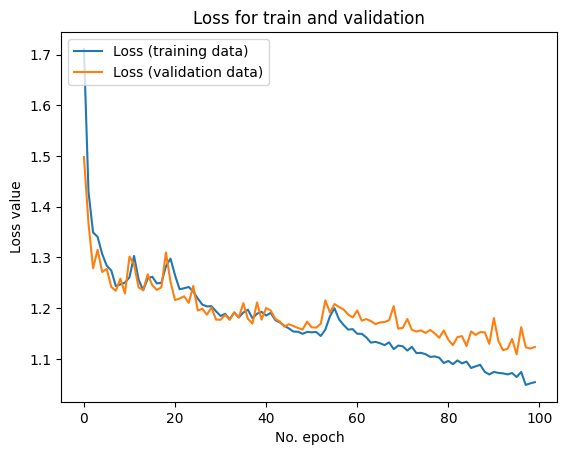

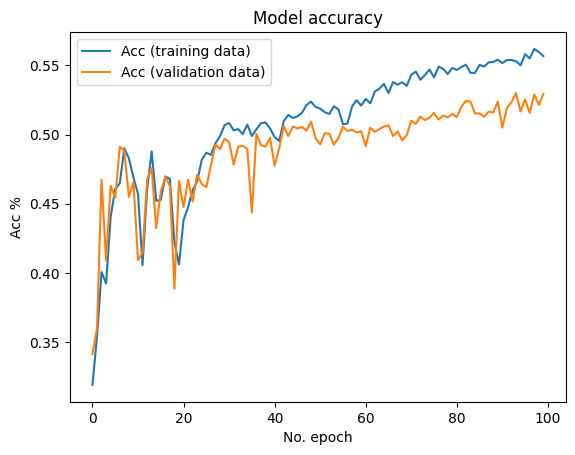

In [35]:
learning_curve(history)

17/17 - 5s - 317ms/step - categorical_accuracy: 0.5299 - loss: 1.1197
Model validation loss: 1.119714617729187
Model validation accuracy: 0.529938280582428
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step
y_val shape: (531, 4)
y_pred shape: (531, 4)


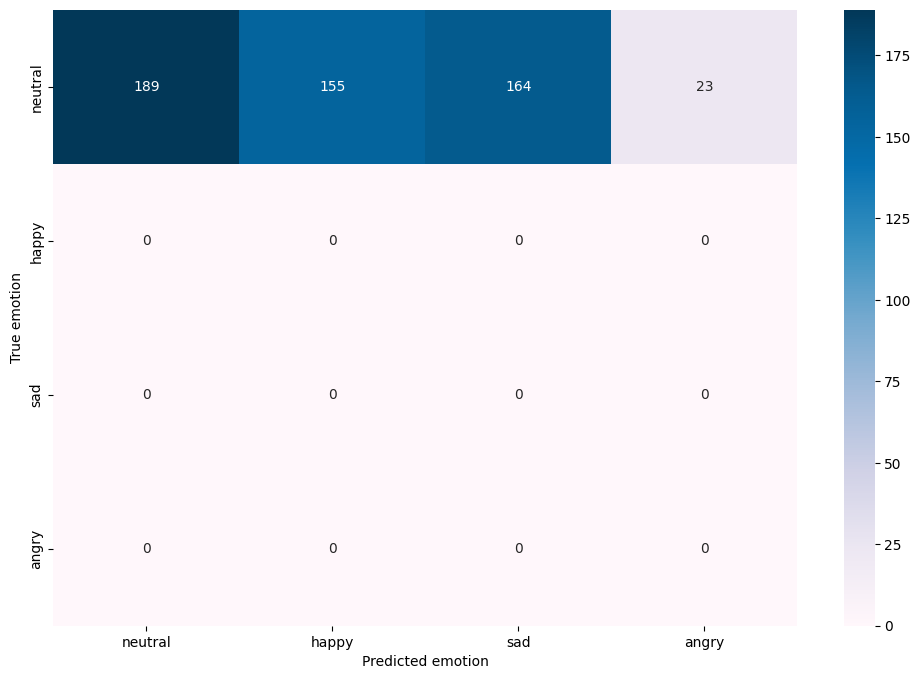

In [67]:
validation_evaluation(model, x_val, y_val)

18/18 - 5s - 305ms/step - categorical_accuracy: 0.3418 - loss: 1.8309
Model test loss: 1.8308939933776855
Model test accuracy: 0.34178638458251953
y_test shape: (549, 501, 4)
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step
y_val shape: (549, 501, 4)
y_pred shape: (549, 4)


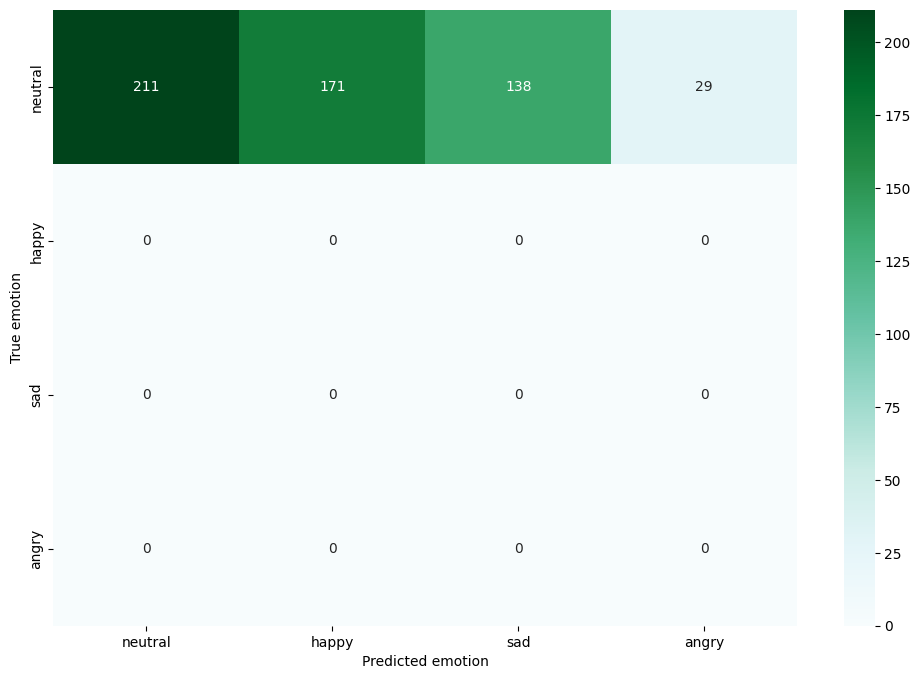

In [76]:
test_evaluation(model, x_test, y_test)

In [19]:
# neuron1 = 64
# neuron2 = 64
# neuron3 = 32
# neuron4 = 32
# l2 = 0.01
# dropout = 0.5
# batch_size = 32
# epochs = 100
# l_rate = 0.001

#train EYASE Augmented dataset 
history, model = lstm(neuron1 = 16,
neuron2 = 16,
neuron3 = 16,
neuron4 = 32,                      
l2= 0.1,
dropout = 0.5,
batch_size = 256,
epochs = 340,
l_rate = 0.001,
output_path = 'best_weights_EYASE_EAED_16_32.keras')

C:\Users\H P\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 501, 155)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 501, 16)             │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 501, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 501, 256)            │         148,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 501, 16)             │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 501, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 501, 4)              │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,156 (606.08 KB)

 Trainable params: 155,156 (606.08 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
 2/10 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - categorical_accuracy: 0.2676 - loss: 10.9807  

KeyboardInterrupt: 

In [ ]:
learning_curve(history)

In [ ]:
validation_evaluation(model, x_val, y_val)

In [ ]:
test_evaluation(model, x_test, y_test)

### CNN MODEL

In [18]:
zcr_cnn, c_stft_cnn, mfcc_cnn, rms_cnn, mel_cnn = reshape_for_cnn(zcr_lstm, c_stft_lstm, mfcc_lstm, rms_lstm, mel_lstm)

In [19]:
print("zcr_cnn", zcr_cnn.shape)
print("c_stft_cnn", c_stft_cnn.shape)
print("mfcc_cnn",mfcc_cnn.shape)
print("rms_cnn", rms_cnn.shape)
print("mel_cnn", mel_cnn.shape)
print("y", y.shape)

zcr_cnn (3541, 501, 1, 1)
c_stft_cnn (3541, 501, 12, 1)
mfcc_cnn (3541, 501, 13, 1)
rms_cnn (3541, 501, 1, 1)
mel_cnn (3541, 501, 128, 1)
y (3541, 1)


In [20]:
# Test that X and y are reay for training on EYASE Dataset
X = concatenate_features(zcr_cnn, c_stft_cnn,  mfcc_cnn, rms_cnn, mel_cnn)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3541, 501, 155, 1)
y shape: (3541, 1)


In [22]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, y, test_size = 0.31, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.5, random_state = 42)


# Get unique values and their counts
unique_classes, class_counts = np.unique(y_val, return_counts=True)

# Print the counts for each class
for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} occurrences")
    
# Get unique values and their counts
unique_classes, class_counts = np.unique(y_test, return_counts=True)

# Print the counts for each class
for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} occurrences")
    
# y_train_resized = np.repeat(y_train[:, np.newaxis, :], 501, axis=1)
# y_val_resized = np.repeat(y_val[:, np.newaxis, :], 501, axis=1)
# y_test_resized = np.repeat(y_val[:, np.newaxis, :], 501, axis=1)
#'One-hot' vectors for Y: emotion classification
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_val = tf.keras.utils.to_categorical(y_val, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)

# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

Class 0: 168 occurrences
Class 1: 91 occurrences
Class 2: 180 occurrences
Class 3: 110 occurrences
Class 0: 170 occurrences
Class 1: 81 occurrences
Class 2: 181 occurrences
Class 3: 117 occurrences
(2443, 501, 155, 1)
(549, 501, 155, 1)
(549, 501, 155, 1)
(2443, 4)
(549, 4)
(549, 4)


In [26]:
history, model = CNN(
batch_size = 64,
epochs = 50,
l_rate = 0.0001,
output_path = 'best_weights_EYASE_EAED_CNN.keras')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 501, 16)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 501, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 501, 32)             │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 501, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 501, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 501, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 501, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 501, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 501, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 64128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       8,208,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,285,156 (31.61 MB)

 Trainable params: 8,284,292 (31.60 MB)

 Non-trainable params: 864 (3.38 KB)

None
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - categorical_accuracy: 0.3101 - loss: 6.8805 - val_categorical_accuracy: 0.2423 - val_loss: 6.5541 - learning_rate: 1.0000e-04
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 716ms/step - categorical_accuracy: 0.3604 - loss: 6.5978 - val_categorical_accuracy: 0.2131 - val_loss: 6.4952 - learning_rate: 1.0000e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 718ms/step - categorical_accuracy: 0.3944 - loss: 6.3618 - val_categorical_accuracy: 0.2022 - val_loss: 6.5058 - learning_rate: 1.0000e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 671ms/step - categorical_accuracy: 0.4529 - loss: 6.1632 - val_categorical_accuracy: 0.2095 - val_loss: 6.3983 - learning_rate: 1.0000e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 659ms/step - categorical_accuracy: 0.4736 - loss: 6.0335 - val_categorical_accuracy: 0.2149 - val_loss: 6.3379 - learning_rate: 1.0000e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 724ms/step - categorical_accuracy: 0.5310 - loss: 5

Epoch 39/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 640ms/step - categorical_accuracy: 0.9159 - loss: 3.1563 - val_categorical_accuracy: 0.4554 - val_loss: 4.3905 - learning_rate: 1.0000e-04
Epoch 40/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 656ms/step - categorical_accuracy: 0.9304 - loss: 3.0852 - val_categorical_accuracy: 0.4736 - val_loss: 4.3876 - learning_rate: 1.0000e-04
Epoch 41/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 658ms/step - categorical_accuracy: 0.9365 - loss: 3.0406 - val_categorical_accuracy: 0.4699 - val_loss: 4.4380 - learning_rate: 1.0000e-04
Epoch 42/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 633ms/step - categorical_accuracy: 0.9393 - loss: 3.0107 - val_categorical_accuracy: 0.4426 - val_loss: 4.4010 - learning_rate: 1.0000e-04
Epoch 43/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - categorical_accuracy: 0.9273 - loss: 2.9917 - val_categorical_accuracy: 0.4499 - val_loss: 4.3773 - learning_rate: 1.0000e-04
Epoch 44/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 646ms/step - categorical_accuracy: 0.9415 - los

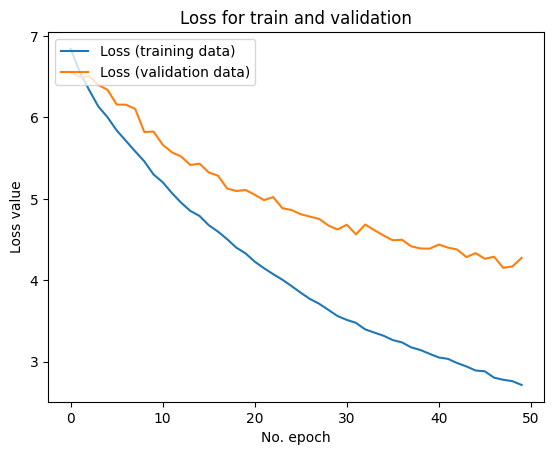

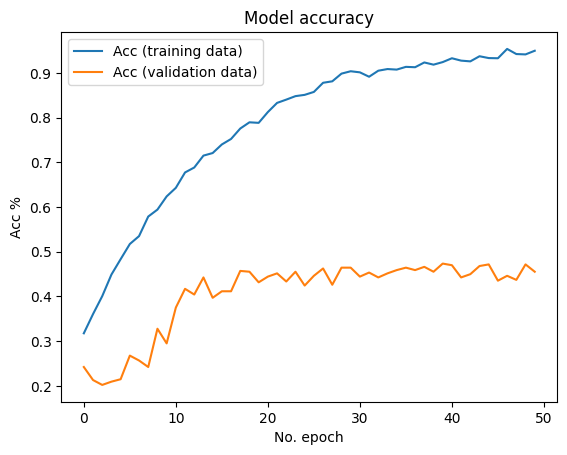

In [27]:
learning_curve(history)